Data analysis and visualization of the Airbnb Boston dataset.

## Introduction

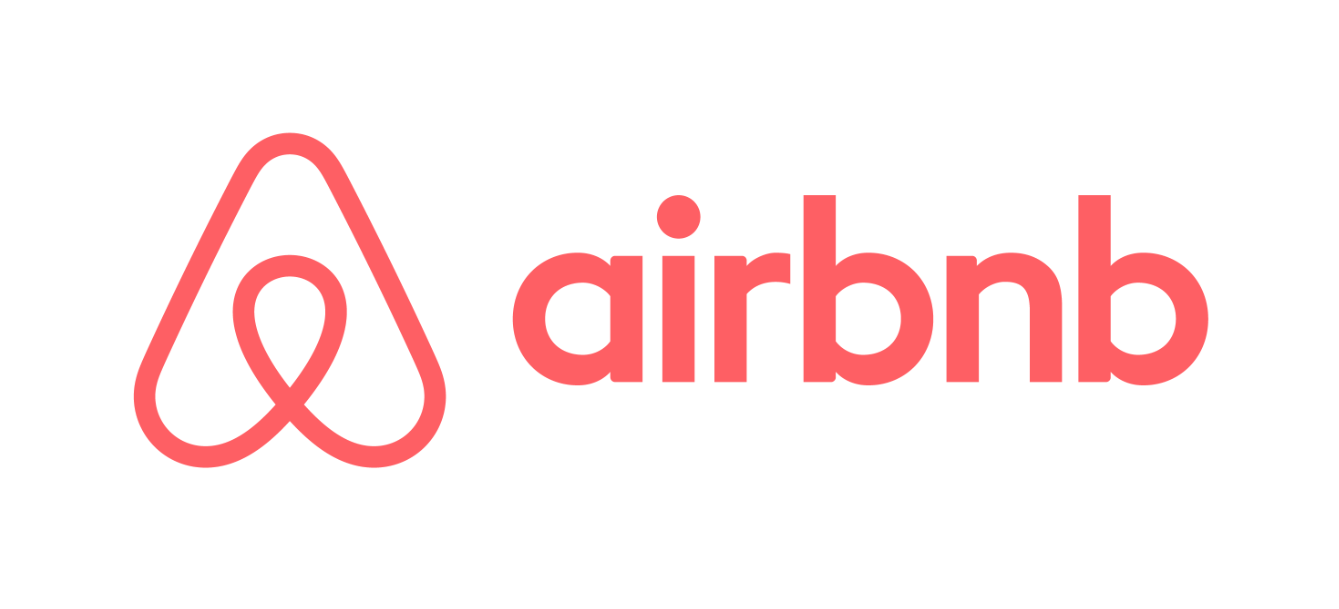

Airbnb is an online marketplace that lets people rent out their properties or spare rooms to other people.
To increase profits, we need to understand the customers' needs in better way. 
In this notebook we will be exploring different neighborhoods, prices, and distribution across the Boston area to better understand the customer.

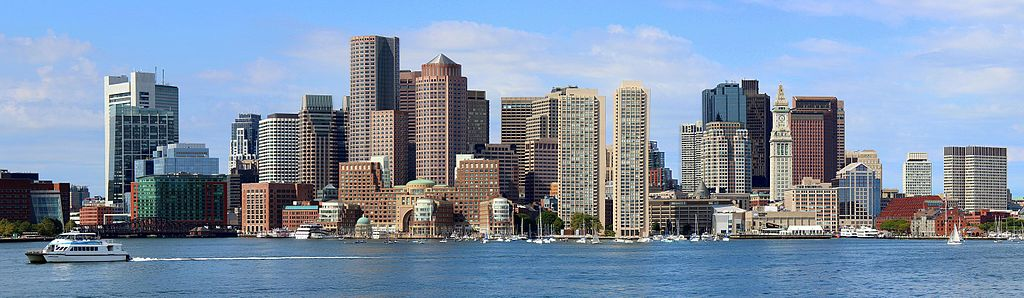

## Business Understanding

<ol>
<li>What are the areas where Airbnb rentals are popular?</li>
<li>What are the most expensive neighborhoods in Boston?</li>
<li>What type of property is most expensive?</li>
<li>What type of rooms are most expensive?</li>
<li>Which neighborhood has the highest review scores?</li>
<li>What is the most frequent words among reviews</li>
</ol>

Part 1: Libraries to import

In [ ]:
!pip install folium

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import folium
from folium.plugins import FastMarkerCluster
from wordcloud import WordCloud, STOPWORDS 
import gensim 
from gensim.models import Word2Vec

In [ ]:
%matplotlib inline

## Data Understanding
In this part we will load the data, check for missing values, and then clean the data for analysis if needed. 

In [ ]:
#Reading the csv file
df_list = pd.read_csv('../input/boston/listings.csv')

In [ ]:
df_list.head()

In [ ]:
df_list.columns

In [ ]:
df_list.describe()

In [ ]:
df_list.dtypes

From the above column types, the one's with object type has to be converted to appropriate data type. We will be converting these columns as and when required to numeric or float or any other type.

## Data Preparation
We will be performing data processing in this part. This includes cleaning, type converting and other data manipulations.

In [ ]:
#We will be using this class for data preprocessing
class Data_Handle:
    def __init__(self,df):
        super(Data_Handle,self).__init__()
        self.df = df
        
    def remove_columns(self,df,drop_cols):
        '''
        INPUT:
        df - the pandas dataframe from which columns has to be dropped
        drop_cols = list of column names that's need to be dropped
        
        OUTPUT:
        df - dataframe with the specified columns removed
        '''
        self.df = df.drop(drop_cols,axis=1)
        return self.df
    
    def print_top_x_missing_percent_cols(self,df,top_x):
        '''
        INPUT:
        df - the pandas dataframe whose percentage of missing value for each column has
        to be printed
        top_x = top x number of columns with most missing value percentage will be
        printed
        
        '''
        null_df = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([null_df, percent], axis=1, keys=['Total', 'Percent'])
        print(missing_data.head(top_x))
        return
    
    def extract_numeric(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which numeric values need to be
        extracted from the specified columns having comma separated cell
        values.
        columns = list of column names from which values have to be 
        extracted
        
        OUTPUT:
        df - dataframe with numeric value extracted.
        '''
        remove_commas = lambda x:''.join(str(x).split(','))
        for col in columns:
            self.df[col] = df[col].apply(remove_commas).str.extract(r'(\d+)').astype(float)
        return self.df
    
    def convert_to_binary(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which columns has to be converted
        to binary
        
        OUTPUT:
        df - dataframe with the specified columns converted to binary
        '''
        for col in columns:
            self.df[col] = df[col].apply(lambda x: 1 if str(x)=='t' else 0 )
        return self.df
    
    def fill_missing_col(self,df,columns,method):
        '''
        INPUT:
        df - the pandas dataframe in which the specified column's
        missing values will be filled
        columns = list of column names that's need to be filled
        method = method used to fill the missing values.
        (median,mean,mode)
        OUTPUT:
        df - dataframe with the specified columns filled.
        '''
        for col in columns:
            if method=='mode':
                self.df[col] = df[col].fillna(df[col].mode()[0])
            elif method=='median':
                self.df[col] = df[col].fillna(df[col].median()[0])
            elif method=='mean':
                self.df[col] = df[col].fillna(df[col].mean())
        
        return self.df
    
    def convert_to_category(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe in which  the columns specified
        will be converted to category variables
        columns = list of column names that's need to be converted
        
        OUTPUT:
        df - dataframe with the specified columns converted to 
        categorical variables.
        '''
        for col in columns:
            self.df = pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col],drop_first=False)],axis=1)
        return self.df
    
    def list_feature_to_count(self,df,column_name,new_column_name):
        '''
        INPUT:
        df - the pandas dataframe from which the specifed column
        will be converted.
        Here a column having values as lists will be converted to
        count of values in the list
        For Ex column value x =['a','b'] this value will converted to 2
        column_name = single column name
        new_column_name = column name for the new values.
        
        OUTPUT:
        df - dataframe with the specified column converted.
        '''
        count_items_in_list = lambda x : len(x.split(',')) 
        self.df[new_column_name] = df[column_name].apply(count_items_in_list)
        self.df = df.drop(columns=[column_name])
        return self.df
            
    
    def remove_rows_missing_col(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which rows will be removed
        which have missing values in the specified columns
        columns = list of column names that's need to be checked
        for missing values.
        
        OUTPUT:
        df - dataframe with the rows removed
        '''
        for col in columns:
            self.df = df.dropna(col)
        return self.df

## Data Modelling
In this part we will be visualizing the data.

###  What are the areas where Airbnb rentals are popular?

In [ ]:
df_neighborhood = df_list['neighbourhood_cleansed'].value_counts()
df_neighborhood = df_neighborhood.reset_index()
temp = df_list[['neighbourhood_cleansed','latitude','longitude']].groupby(['neighbourhood_cleansed'],as_index=False).mean()
df_neighborhood.reset_index
df_neighborhood['latitude'] = temp['latitude']
df_neighborhood['longitude'] = temp['latitude']

In [ ]:
column1 = 'index'
column2 = 'neighbourhood_cleansed'
m = folium.Map(location=[42.3601, -71.0589], tiles='cartodbpositron',zoom_start=11)

for i in list(df_neighborhood[column1]):
    folium.CircleMarker([float(df_neighborhood[df_neighborhood[column1]==i]['latitude']),
                   float(df_neighborhood[df_neighborhood[column1]==i]['longitude'])]
              ,popup=str(i)+": "+str(df_neighborhood[df_neighborhood[column1]==i][column2])
                 ,icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(m)
folium.Choropleth(
    geo_data='../input/boston-json/boston-neighborhoods.json',
    name='choropleth',
    data=df_neighborhood,
    columns=['index','neighbourhood_cleansed'],
    key_on='properties.Name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Density of Airbnb Homestays'
).add_to(m)
folium.LayerControl().add_to(m)
m

By looking at the density of Airbnb rentals in different neighborhoods. We can see that the central and upper regions of Boston are popular/ densely populated with Airbnb rentals.

In [ ]:
#Let's look at the above density map in a more interactive way.
latitude = df_list['latitude'].tolist()
longitude = df_list['longitude'].tolist()
locations = list(zip(latitude, longitude))

map1 = folium.Map(location=[42.3601, -71.0589], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

Lets quantify the above data and plot them on graph

In [ ]:
data = Data_Handle(df_list) #create of object of the Data_Handle class

In [ ]:
#First we will extract numeric values from the specified columns 
#becuase they have comma separated values.
numeric_cols = ['extra_people','host_response_rate','host_acceptance_rate','price','monthly_price','weekly_price','security_deposit','cleaning_fee']
df_list = data.extract_numeric(df_list,numeric_cols)

In [ ]:
dense_neighbourhood = df_list['neighbourhood_cleansed'].value_counts()
dense_neighbourhood =dense_neighbourhood.reset_index()
dense_neighbourhood =dense_neighbourhood.rename(columns={'index':'neighbourhood_cleansed','neighbourhood_cleansed':'count'})
dense_neighbourhood['percent'] = dense_neighbourhood['count'].apply(lambda x:100*x/sum(dense_neighbourhood['count']))
x=dense_neighbourhood['neighbourhood_cleansed']
y=dense_neighbourhood['count']
size =dense_neighbourhood['percent']*10
trace1 = go.Scatter(x=x,y=y,name='popular neighbourhood',mode = 'markers', 
    marker=dict( 
        size=size, 
        sizemode='area', 
        sizeref=2.*max(size)/(40.**2), 
        sizemin=4,
        color = size/10,
        showscale = True,
    ) )
layout = go.Layout(title="Number of Airbnb rentals across different Neighbourhood", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

### What are the most expensive neighborhoods in Boston?

Let's look at the rental cost across different neighborhoods

In [ ]:
temp2 = df_list[['neighbourhood_cleansed','price']].groupby(['neighbourhood_cleansed'],as_index=False).mean()
df_neighborhood['price'] = temp2['price']

In [ ]:
m1 = folium.Map(location=[42.3601, -71.0589], tiles='cartodbpositron',zoom_start=10)


folium.Choropleth(
    geo_data='../input/boston-json/boston-neighborhoods.json',
    name='choropleth',
    data=df_neighborhood,
    columns=['index','price'],
    key_on='properties.Name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Average Price of Airbnb Homestay across different neighborhoods'
).add_to(m1)

folium.LayerControl().add_to(m1)
m1

In [ ]:
#Let's look the above map in a more quantitative way
expensive_neighbourhood = df_list.groupby(['neighbourhood_cleansed']).mean()['price'].sort_values(ascending=True)
expensive_neighbourhood =expensive_neighbourhood.reset_index()
x=expensive_neighbourhood['neighbourhood_cleansed']
y=expensive_neighbourhood['price']
trace1 = go.Bar(x=y,y=x,orientation='h',marker=dict(color='#ffdc51'),name='Average price of airbnb rental neighbourhood')
layout = go.Layout(title="Average price of airbnb rentals across different neighbourhood"
                   ,legend=dict(x=0.1, y=1.1, orientation="h")
                   ,xaxis=dict(title="Average Price"),
                   yaxis=dict(title="Neighborhoods"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

From the map we can see that the most expensive districts are at the central region of Boston.

In [ ]:
#How property type and price are related 
expensive_property = df_list.groupby(['property_type']).mean()['price'].sort_values(ascending=True)
expensive_property =expensive_property.reset_index()
x=expensive_property['property_type']
y=expensive_property['price']
trace1 = go.Bar(x=y,y=x,marker=dict(color='#ffdc51'),name='Expensive Property',orientation='h')
layout = go.Layout(title="Price distribution across property type"
                   ,legend=dict(x=0.1, y=1.1, orientation="h")
                   ,xaxis=dict(title="Average Price"),
                   yaxis=dict(title="Property Type"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

### What type of rooms are most expensive?

In [ ]:
#How room type and price are related 
expensive_room = df_list.groupby(['room_type']).mean()['price'].sort_values(ascending=False)
expensive_room =expensive_room.reset_index()
x=expensive_room['room_type']
y=expensive_room['price']
trace1 = go.Bar(x=x,y=y,marker=dict(color='#ffdc51'),name='Expensive Property')
layout = go.Layout(title="Distribution of price across room type", legend=dict(x=0.1, y=1.1, orientation="h")
                  ,xaxis=dict(title="Average Price"),
                   yaxis=dict(title="Room Type"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

### Which neighborhood has the highest review scores?

In [ ]:
#Review scores of neighbourhood
highly_rated_neighbourhood = df_list.groupby(['neighbourhood_cleansed']).mean()['review_scores_value'].sort_values(ascending=True)
highly_rated_neighbourhood =highly_rated_neighbourhood.reset_index()
x=highly_rated_neighbourhood['neighbourhood_cleansed']
y=highly_rated_neighbourhood['review_scores_value']
trace1 = go.Bar(x=y,y=x,marker=dict(color='#ffdc51'),name='high rated neighbourhood',orientation="h")
layout = go.Layout(title="Average review scores of Neighbourhood", legend=dict(x=0.1, y=1.1, orientation="h")
                  ,xaxis=dict(title="Average Review Score"),
                   yaxis=dict(title="Neighborhoods"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

Now we will do some text analysis of the reviews

### What is the most frequent words among reviews

In [ ]:
#Here we will visualize the most frequent words in reviews
stopwords = set(STOPWORDS)
desc_words = '' 
for desc in df_list['description']:
    desc = str(desc)
    tokens = desc.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    desc_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords,max_words=100, 
                min_font_size = 10).generate(desc_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
word_list=[]
for desc in df_list['description']:
    desc = str(desc)
    tokens = desc.split() 
    word_list.append(tokens)

In [ ]:
model_bow = gensim.models.Word2Vec(word_list, min_count = 1,  
                               window = 5) 

After looking at the word cloud of most frequent words,
now we will see what are the words that are used in the context of the most frequent words

In [ ]:
most_frequent=['boston','guest','room','close']
for word in most_frequent:
    d=model_bow.most_similar(word,topn=40)
    res ={}
    for x in d: 
        res[x[0]] = x[1]
    wordcloud = WordCloud(width = 200, height = 200, 
                background_color ='white', 
                stopwords = stopwords,max_words=40, 
                min_font_size = 7).generate_from_frequencies(frequencies=res) 

    # plot the WordCloud image    
    print("For:",word)
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

## Evaluation
From the figures above, we can draw following results
1. Central regions are expensive as well as popular.
2. If you are a solo traveler, you can find private rooms at a cost similar to shared rooms.
3. Entire apartments higher much more than shared or private rooms.